In [79]:
import math, re, os
import numpy as np
import tensorflow as tf

print("Tensorflow version " + tf.__version__)


Tensorflow version 2.14.0


In [80]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver() 
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() 

print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


In [81]:
# Local file address
local_file_path = '/Users/shivarjunpawan/Desktop/tpu-getting-started/tfrecords-jpeg-512x512'

In [82]:
def random_erasing(img, sl=0.1, sh=0.2, rl=0.4, p=0.3):
    h = tf.shape(img)[0]
    w = tf.shape(img)[1]
    c = tf.shape(img)[2]
    origin_area = tf.cast(h*w, tf.float32)

    e_size_l = tf.cast(tf.round(tf.sqrt(origin_area * sl * rl)), tf.int32)
    e_size_h = tf.cast(tf.round(tf.sqrt(origin_area * sh / rl)), tf.int32)

    e_height_h = tf.minimum(e_size_h, h)
    e_width_h = tf.minimum(e_size_h, w)

    erase_height = tf.random.uniform(shape=[], minval=e_size_l, maxval=e_height_h, dtype=tf.int32)
    erase_width = tf.random.uniform(shape=[], minval=e_size_l, maxval=e_width_h, dtype=tf.int32)

    erase_area = tf.zeros(shape=[erase_height, erase_width, c])
    erase_area = tf.cast(erase_area, tf.uint8)

    pad_h = h - erase_height
    pad_top = tf.random.uniform(shape=[], minval=0, maxval=pad_h, dtype=tf.int32)
    pad_bottom = pad_h - pad_top

    pad_w = w - erase_width
    pad_left = tf.random.uniform(shape=[], minval=0, maxval=pad_w, dtype=tf.int32)
    pad_right = pad_w - pad_left

    erase_mask = tf.pad([erase_area], [[0,0],[pad_top, pad_bottom], [pad_left, pad_right], [0,0]], constant_values=1)
    erase_mask = tf.squeeze(erase_mask, axis=0)
    erased_img = tf.multiply(tf.cast(img,tf.float32), tf.cast(erase_mask, tf.float32))

    return tf.cond(tf.random.uniform([], 0, 1) > p, lambda: tf.cast(img, img.dtype), lambda:  tf.cast(erased_img, img.dtype))

In [85]:
import os
from PIL import Image
import numpy as np
import tensorflow as tf

# Function to load images from a directory
def load_images_from_files(images_path):
    image_files = os.listdir(images_path)
    images = [np.array(Image.open(os.path.join(images_path, img_file))) for img_file in image_files]
    return np.array(images)

# Function to load labels from a text file
def load_labels_from_files(labels_path):
    with open(labels_path, 'r') as file:
        labels = [int(line.strip()) for line in file.readlines()]
    return np.array(labels)

# Assuming you have functions to load your data
def load_train_data():
    # Replace these paths with your actual data paths
    train_images_path = '/Users/shivarjunpawan/Desktop/tpu-getting-started/tfrecords-jpeg-512x512/train'
    train_labels_path = '/Users/shivarjunpawan/Desktop/tpu-getting-started/tfrecords-jpeg-512x512/train'

    train_images = load_images_from_files(train_images_path)
    train_labels = load_labels_from_files(train_labels_path)
    return train_images, train_labels

def load_validation_data():
    # Replace these paths with your actual data paths
    val_images_path = '/Users/shivarjunpawan/Desktop/tpu-getting-started/tfrecords-jpeg-512x512/val'
    val_labels_path = '/Users/shivarjunpawan/Desktop/tpu-getting-started/tfrecords-jpeg-512x512/val'

    val_images = load_images_from_files(val_images_path)
    val_labels = load_labels_from_files(val_labels_path)
    return val_images, val_labels

def load_test_data():
    # Replace these paths with your actual data paths
    test_images_path = '/Users/shivarjunpawan/Desktop/tpu-getting-started/tfrecords-jpeg-512x512/test'
    test_labels_path = '/Users/shivarjunpawan/Desktop/tpu-getting-started/tfrecords-jpeg-512x512/test'

    test_images = load_images_from_files(test_images_path)
    test_labels = load_labels_from_files(test_labels_path)
    return test_images, test_labels

# Load your data
train_images, train_labels = load_train_data()
val_images, val_labels = load_validation_data()
test_images, test_labels = load_test_data()

# Now you can use these functions in your code
BATCH_SIZE = 16  # You can adjust the batch size

# Assuming you have the appropriate data loaded in train_images, train_labels, val_images, val_labels
def get_training_dataset():
    # Example: Load and preprocess your training dataset using tf.data.Dataset
    train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
    train_dataset = train_dataset.shuffle(buffer_size=10000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return train_dataset

def get_validation_dataset():
    # Example: Load and preprocess your validation dataset using tf.data.Dataset
    val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_labels))
    val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return val_dataset

def get_test_dataset():
    # Example: Load and preprocess your test dataset using tf.data.Dataset
    test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels))
    test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return test_dataset

ds_train = get_training_dataset()
ds_valid = get_validation_dataset()
ds_test = get_test_dataset()

print("Training:", ds_train)
print("Validation:", ds_valid)
print("Test:", ds_test)


UnidentifiedImageError: cannot identify image file '/Users/shivarjunpawan/Desktop/tpu-getting-started/tfrecords-jpeg-512x512/train/03-512x512-798.tfrec'

In [ ]:
np.set_printoptions(threshold=15, linewidth=80)

print("Training data shapes:")
for image, label in ds_train.take(3):
    print(image.numpy().shape, label.numpy().shape)
print("Training data label examples:", label.numpy())

Training data shapes:
(16, 224, 224, 3) (16,)
(16, 224, 224, 3) (16,)
(16, 224, 224, 3) (16,)
Training data label examples: [1 0 1 ... 1 1 0]


In [ ]:
print("Test data shapes:")
for image, idnum in ds_test.take(3):
    print(image.numpy().shape, idnum.numpy().shape)
print("Test data IDs:", idnum.numpy().astype('U')) # U=unicode string

Test data shapes:
(16, 224, 224, 3) (16,)
(14, 224, 224, 3) (14,)
Test data IDs: ['0' '0' '0' '0' '0' '1' '1' '1' '1' '1' '0' '0' '1' '1']


In [ ]:
ds_iter = iter(ds_train.unbatch().batch(25))

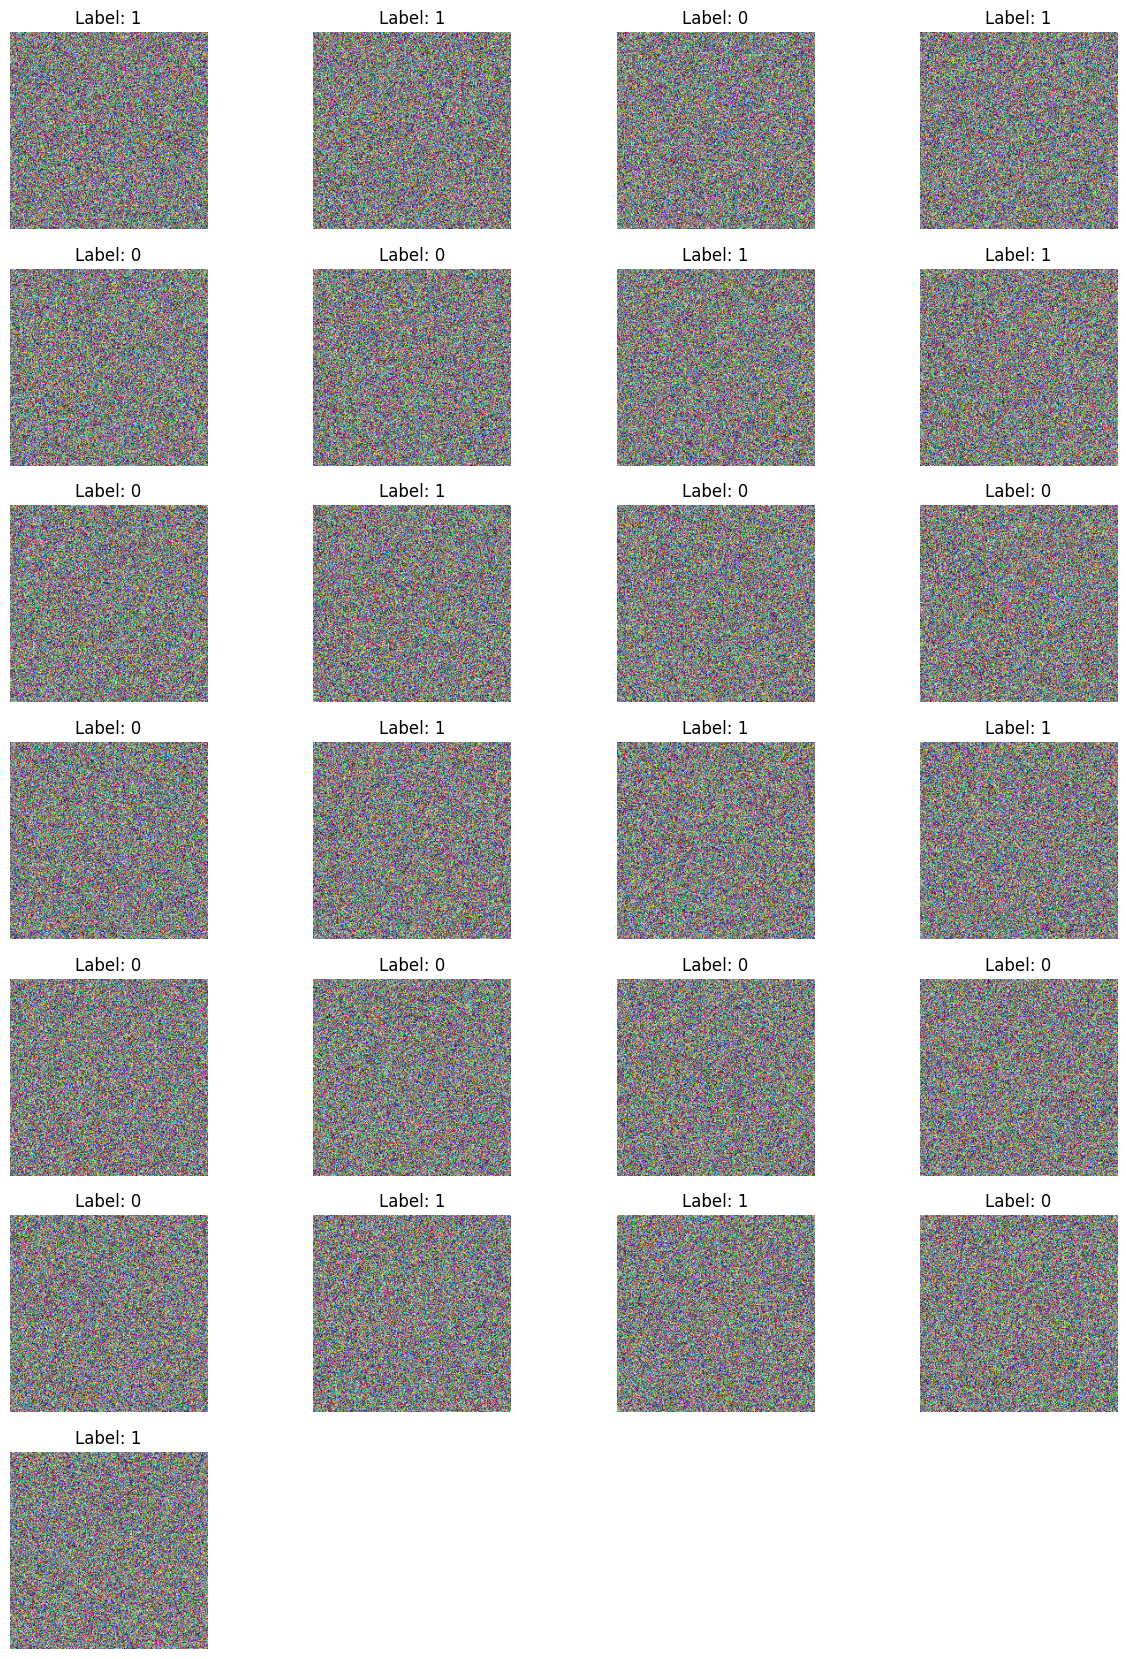

In [ ]:
import matplotlib.pyplot as plt
import math  # Import the math module for ceiling function

def display_batch_of_images(batch):
    # Assuming batch is a tuple of images and labels
    images, labels = batch
    
    # Calculate the number of rows and columns dynamically
    num_images = len(images)
    rows = math.ceil(num_images / 4)  # Assuming 4 images per row
    cols = min(4, num_images)
    
    plt.figure(figsize=(15, 3 * rows))
    
    for i in range(num_images):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(images[i])
        plt.title(f"Label: {labels[i]}")
        plt.axis("off")
    
    plt.show()

# Assuming you have already executed the code to get ds_train and created ds_iter
one_batch = next(ds_iter)
display_batch_of_images(one_batch)


In [ ]:
import efficientnet.tfkeras as efn
import ssl

# Disable SSL certificate verification (not recommended for security reasons)
ssl._create_default_https_context = ssl._create_unverified_context


In [ ]:
EPOCHS = 55

with strategy.scope():
    pretrained_model = tf.keras.applications.InceptionResNetV2(
        weights='imagenet',
        include_top=False ,
        input_shape=[*IMAGE_SIZE, 3]
    )
    pretrained_model.trainable = True
    for each_layer in pretrained_model.layers[:30]:
        each_layer.trainable =  False
    model_ir2 = tf.keras.Sequential([
        # To a base pretrained on ImageNet to extract features from images...
        pretrained_model,
        # ... attach a new head to act as a classifier.
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(len(CLASSES), activation='softmax')
    ])
    model_ir2.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss = 'sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy'],
)

model_ir2.summary()
with strategy.scope():
    pretrained_model_eb7 = efn.EfficientNetB7(
        weights='noisy-student',
        include_top=False ,
        input_shape=[*IMAGE_SIZE, 3]
    )
    pretrained_model_eb7.trainable = True
    model_eb7 = tf.keras.Sequential([
        pretrained_model_eb7,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(len(CLASSES), activation='softmax')
    ])
    model_eb7.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
        loss = 'sparse_categorical_crossentropy',
        metrics=['sparse_categorical_accuracy'],
    )
model_eb7.summary()

219055592/219055592 [==============================] - 11s 0us/step


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Funct  (None, 14, 14, 1536)      54336736  
 ional)                                                          
                                                                 
 global_average_pooling2d (  (None, 1536)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 104)               159848    
                                                                 
Total params: 54496584 (207.89 MB)
Trainable params: 54091528 (206.34 MB)
Non-trainable params: 405056 (1.55 MB)
_________________________________________________________________
258068648/258068648 [==============================] - 13s 0us/step


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnet-b7 (Functiona  (None, 16, 16, 2560)      64097680  
 l)                                                              
                                                                 
 global_average_pooling2d_1  (None, 2560)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_1 (Dense)             (None, 104)               266344    
                                                                 
Total params: 64364024 (245.53 MB)
Trainable params: 64053304 (244.34 MB)
Non-trainable params: 310720 (1.19 MB)
_________________________________________________________________


In [ ]:
import tensorflow as tf

# Define a simple learning rate schedule callback
def lr_schedule(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

# Assuming you want to use this callback in your training
lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_schedule)


In [ ]:
EPOCHS = 25
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE

history = model_ir2.fit(
    ds_train,
    validation_data=ds_valid,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[lr_callback],
)
history1 = model_eb7.fit(
    ds_train,
    validation_data=ds_valid,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[lr_callback],
)

Epoch 1/25


ValueError: in user code:

    File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py", line 1377, in train_function  *
        return step_function(self, iterator)
    File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py", line 1360, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py", line 1349, in run_step  **
        outputs = model.train_step(data)
    File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py", line 1126, in train_step
        y_pred = self(x, training=True)
    File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential" is incompatible with the layer: expected shape=(None, 512, 512, 3), found shape=(None, 224, 224, 3)


In [ ]:
display_training_curves(
    history.history['loss'],
    history.history['val_loss'],
    'loss',
    211,
)
display_training_curves(
    history.history['sparse_categorical_accuracy'],
    history.history['val_sparse_categorical_accuracy'],
    'accuracy',
    212,
)
display_training_curves(
    history1.history['loss'],
    history1.history['val_loss'],
    'loss',
    211,
)
display_training_curves(
    history1.history['sparse_categorical_accuracy'],
    history1.history['val_sparse_categorical_accuracy'],
    'accuracy',
    212,
)

NameError: name 'display_training_curves' is not defined

In [ ]:
cmdataset = get_validation_dataset(ordered=True)
images_ds = cmdataset.map(lambda image, label: image)
labels_ds = cmdataset.map(lambda image, label: label).unbatch()

cm_correct_labels = next(iter(labels_ds.batch(NUM_VALIDATION_IMAGES))).numpy()
cm_probabilities_ir2 = model_ir2.predict(images_ds)
cm_probabilities_eb7 = model_eb7.predict(images_ds)
cm_predictions = np.argmax((cm_probabilities_ir2+cm_probabilities_eb7)/2, axis=-1)

labels = range(len(CLASSES))
cmat = confusion_matrix(
    cm_correct_labels,
    cm_predictions,
    labels=labels,
)
cmat = (cmat.T / cmat.sum(axis=1)).T 

TypeError: get_validation_dataset() got an unexpected keyword argument 'ordered'

In [ ]:
score = f1_score(
    cm_correct_labels,
    cm_predictions,
    labels=labels,
    average='macro',
)
precision = precision_score(
    cm_correct_labels,
    cm_predictions,
    labels=labels,
    average='macro',
)
recall = recall_score(
    cm_correct_labels,
    cm_predictions,
    labels=labels,
    average='macro',
)
print(f"Precision: {precision}\nRecall: {recall}\nF1-score: {score}")

NameError: name 'f1_score' is not defined

In [ ]:
score = f1_score(
    cm_correct_labels,
    cm_predictions,
    labels=labels,
    average='macro',
)
precision = precision_score(
    cm_correct_labels,
    cm_predictions,
    labels=labels,
    average='macro',
)
recall = recall_score(
    cm_correct_labels,
    cm_predictions,
    labels=labels,
    average='macro',
)
display_confusion_matrix(cmat, score, precision, recall)

In [ ]:
dataset = get_validation_dataset()
dataset = dataset.unbatch().batch(20)
batch = iter(dataset)

In [ ]:
images, labels = next(batch)
probabilities_ir2 = model_ir2.predict(images)
probabilities_eb7 = model_eb7.predict(images)
predictions = np.argmax((probabilities_ir2+probabilities_eb7)/2, axis=-1)
display_batch_of_images((images, labels), predictions)

NameError: name 'batch' is not defined

In [ ]:
test_ds = get_test_dataset(ordered=True)

print('Computing predictions...')
test_images_ds = test_ds.map(lambda image, idnum: image)
probabilities_ir2 = model_ir2.predict(test_images_ds)
probabilities_eb7 = model_eb7.predict(test_images_ds)
predictions = np.argmax((probabilities_ir2+probabilities_eb7)/2, axis=-1)
print(predictions)

In [ ]:
print('Generating submission.csv file...')

# Get image ids from test set and convert to unicode
test_ids_ds = test_ds.map(lambda image, idnum: idnum).unbatch()
test_ids = next(iter(test_ids_ds.batch(NUM_TEST_IMAGES))).numpy().astype('U')

# Write the submission file
np.savetxt(
    'submission.csv',
    np.rec.fromarrays([test_ids, predictions]),
    fmt=['%s', '%d'],
    delimiter=',',
    header='id,label',
    comments='',
)

# Look at the first few predictions
!head submission.csv
